In [48]:
import requests
import os

from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import natural_earth
import shapefile
import numpy as np
from glob import glob
import xarray as xr

import sys
sys.path.append('../scripts')
from plotting_tools import get_tle_files, load_data, plot_ptype, plot_hrrr_ptype

In [23]:
reqheaders = {
    'content-type':'application/json',
    'Authorization': f'Token {os.environ["MPING_KEY"]}'
}

colors = {
    'Rain': 'limegreen', # Rain
    'Snow and/or Graupel': 'aqua',  # Snow
    'Freezing Rain': 'red',  # Freezing rain
    'Ice Pellets/Sleet': 'fuchsia'  # sleet
}

def get_json(reqheaders, year, month, day, hour=None):
    if hour:
        reqparams = {
            'year': str(year),
            'month': str(month).zfill(2),
            'day': str(day).zfill(2),
            'hour': str(hour).zfill(2),
            'category': 'Rain/Snow',
            #'description_contains': 'Freezing',
            #'description_contains': 'Rain Freezing Sleet Ice Pellets Snow',
            'in_bbox': '-109.95744,35.991173,-89.03314,48.241467'
        }
    else:
        reqparams = {
            'year': str(year),
            'month': str(month).zfill(2),
            'day': str(day).zfill(2),
            'category': 'Rain/Snow',
            #'description_contains': 'Freezing',
            #'description_contains': 'Rain Freezing Sleet Ice Pellets Snow',
            'in_bbox': '-109.95744,35.991173,-89.03314,48.241467'
        }
        
    url = 'http://mping.ou.edu/mping/api/v2/reports'
    response = requests.get(url, params=reqparams, headers=reqheaders)

    if response.status_code != 200:
        print('Request Failed with status code %i', response.status_code)
        print("Response Reason:", response.reason)
        print("Response Content:", response.content)
        return None
    else:
        print('Request Successful')
        data = response.json()
        # Pretty print the data
        #print(json.dumps(data,indent=4))
        return data


In [24]:
def plot_mping(ax, data, colors):
    for res in data['results']:
        if res['description'] in colors:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color=colors[res['description']], label=res['description'])
    
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in colors.items()]
    ax.legend(handles=handles, loc='upper left')
    #ax.legend(loc='upper left')
    shapefile_path = natural_earth(resolution='50m', category='cultural', name='populated_places')
    reader = shapefile.Reader(shapefile_path)
    for record in reader.iterShapeRecords():
        city = record.record['NAME']
        lon, lat = record.shape.points[0]
        if -108 <= lon <= -89 and 37 <= lat <= 48:  # Filter cities within the map extent
            ax.plot(lon, lat, 'o', color='black', markersize=5, transform=ccrs.PlateCarree())
            ax.text(lon, lat, city, fontsize=8, transform=ccrs.PlateCarree(), ha='right')

    return ax

## Case Study 1: 2024-03-24 1400

In [25]:
valid_time = f'2024-03-24 1400'
base_path = '/glade/derecho/scratch/cbecker/ptype_real_time/winter_2023_2024/hrrr'
n_members = 18
variables = [
    'u10', 'v10', 'ML_rain', 'ML_crain', 'ML_snow', 'ML_csnow', 'ML_frzr', 'ML_cfrzr', 'ML_icep', 'ML_cicep',
    'crain', 'csnow', 'cfrzr', 'cicep', 'ML_rain_ale', 'ML_rain_epi', 'ML_snow_ale', 'ML_snow_epi', 'ML_frzr_ale',
    'ML_frzr_epi', 'ML_icep_ale', 'ML_icep_epi'
]

colors = {
    'Rain': 'limegreen', # Rain
    'Snow and/or Graupel': 'aqua',  # Snow
    'Freezing Rain': 'red',  # Freezing rain
    'Ice Pellets/Sleet': 'fuchsia'  # sleet
}

tle_files = get_tle_files(base_path, valid_time, n_members)

When making the query to the mPING API, specify year, month, day, and hour. The hour field grabs data from the hour following the requested hour.

In [135]:
json_data = get_json(reqheaders, 2024, 3, 24, 14)
json_data['results'][:5]

Request Successful


[{'id': 3908778,
  'obtime': '2024-03-24T14:00:35Z',
  'category': 'Rain/Snow',
  'description': 'Snow and/or Graupel',
  'description_id': 8,
  'geom': {'type': 'Point', 'coordinates': [-92.87374, 43.0522754]}},
 {'id': 3908780,
  'obtime': '2024-03-24T14:02:54Z',
  'category': 'Rain/Snow',
  'description': 'Snow and/or Graupel',
  'description_id': 8,
  'geom': {'type': 'Point', 'coordinates': [-93.7026074, 45.3404383]}},
 {'id': 3908782,
  'obtime': '2024-03-24T14:03:32Z',
  'category': 'Rain/Snow',
  'description': 'Rain',
  'description_id': 3,
  'geom': {'type': 'Point',
   'coordinates': [-97.86930492734356, 38.08625623966459]}},
 {'id': 3908783,
  'obtime': '2024-03-24T14:04:22Z',
  'category': 'Rain/Snow',
  'description': 'Rain',
  'description_id': 3,
  'geom': {'type': 'Point',
   'coordinates': [-97.93079704417994, 38.05871371724585]}},
 {'id': 3908784,
  'obtime': '2024-03-24T14:04:38Z',
  'category': 'Rain/Snow',
  'description': 'Snow and/or Graupel',
  'description_id'

Plotting mPING data over ptype categorization

In [80]:
ds = load_data(tle_files, variables)

Evidental model ptype categorization

Text(0.5, 1.0, 'TLE 2024-03-24 1400 Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

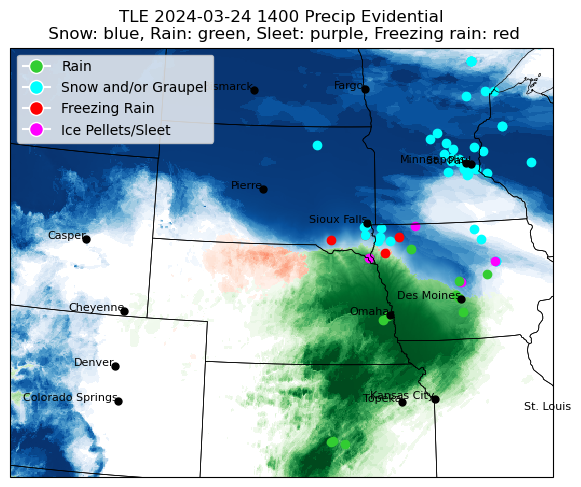

In [136]:
ax = plot_ptype(ds)
plot_mping(ax, json_data, colors)
plt.title(f'TLE {valid_time} Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

HRRR categorization

Text(0.5, 1.0, 'TLE 2024-03-24 1400 Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

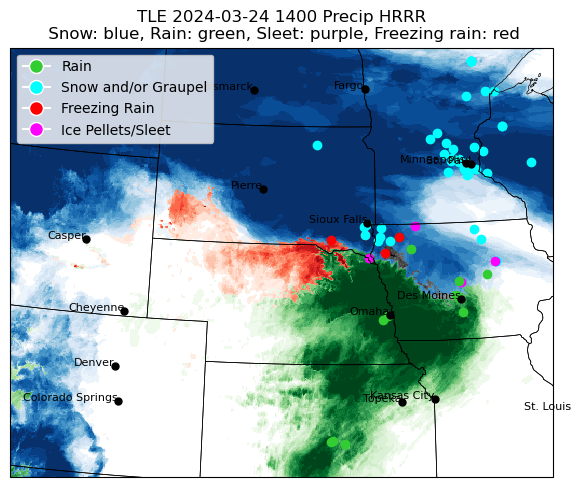

In [137]:
ax = plot_hrrr_ptype(ds)
plot_mping(ax, json_data, colors)
plt.title(f'TLE {valid_time} Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

This doesn't tell the full story, especially since we make the categorizations in the Evidential model by taking the maximum probability across the 4 ptypes. Then if two probabilities are relatively close, that won't be represented in this plot. Instead, plot the mPING data on top of its corresponding probability. 

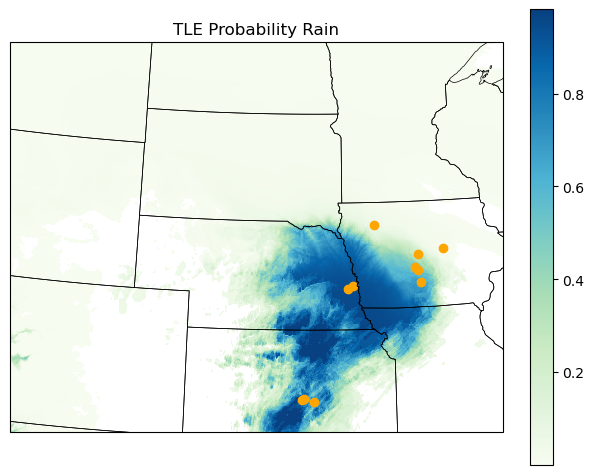

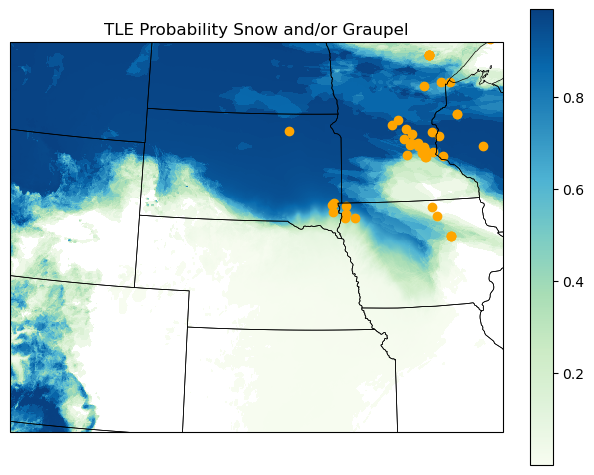

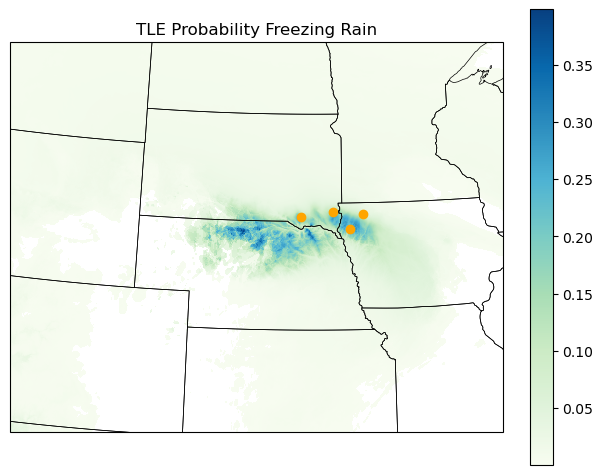

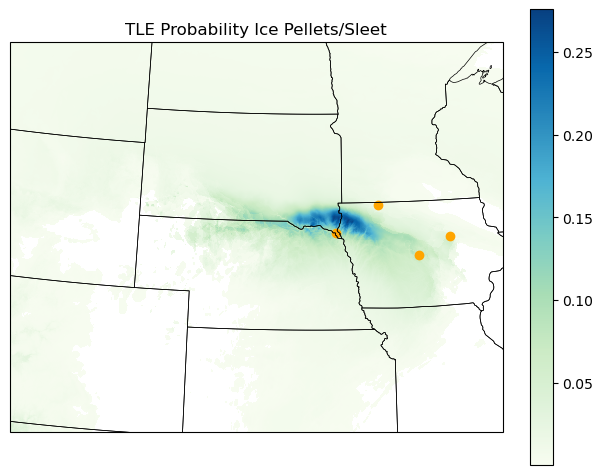

In [51]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='orange', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'TLE Probability {longn_ptype}')

Here's some similar plots as above although since we don't have probabilities for HRRR per say, we can instead calculate the mean across all 18 ensemble members, which represents proportions. 

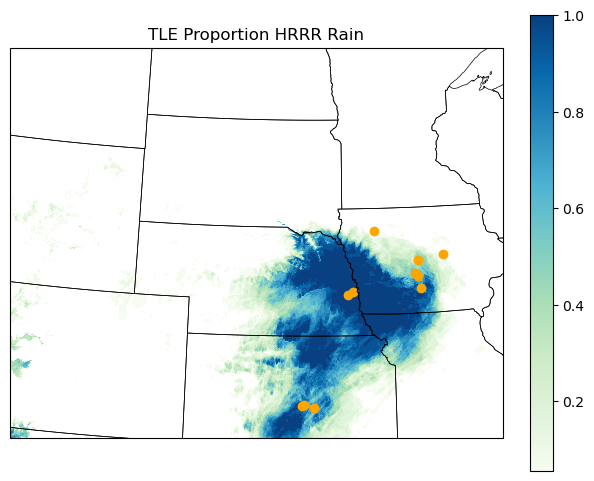

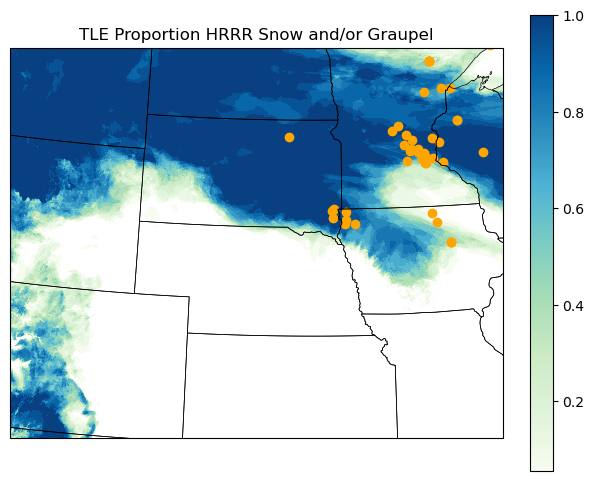

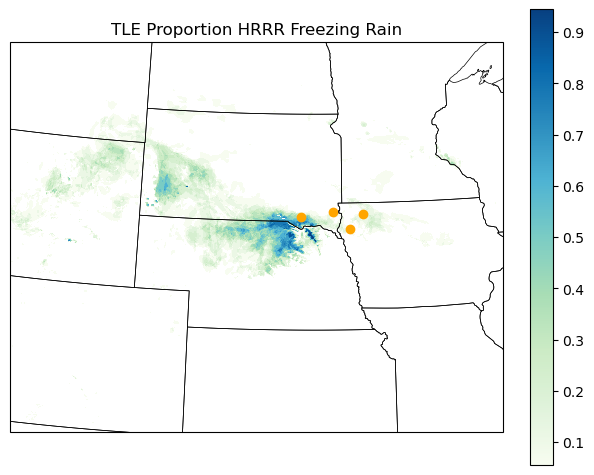

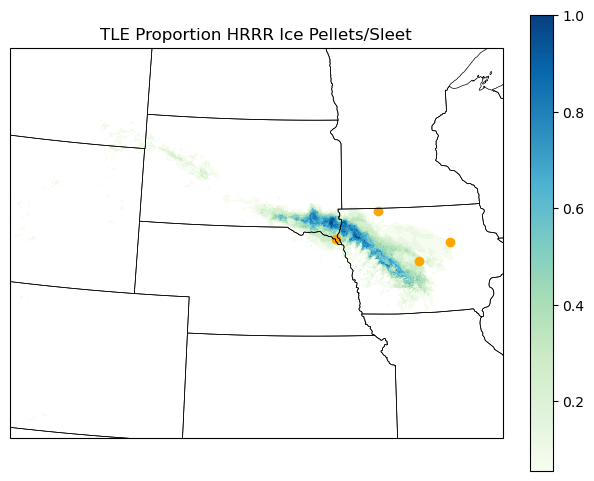

In [120]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'c{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='orange', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'TLE Proportion HRRR {longn_ptype}')

Let's take a closer look at some of the locations which don't match high probabilities

In [83]:
icep_coords = []
for res in json_data['results']:
    if res['description'] == 'Ice Pellets/Sleet':
        coord = res['geom']['coordinates']
        icep_coords.append((coord[0] + 360, coord[1]))

icep_coords

[(264.9072453, 43.4412225),
 (263.3208671, 42.6821695),
 (267.5674964152255, 42.50004392109662),
 (266.38833691673403, 42.017186341055506)]

In [53]:
# find closet indices in lat, lon grids to the coordinates

In [108]:
lat = ds.latitude.values
lon = ds.longitude.values
print(lat.shape)
indices = []
lcc = ccrs.PlateCarree()
for lon_p, lat_p in icep_coords:
    x_p, y_p= lcc.transform_point(lon_p, lat_p, src_crs=ccrs.PlateCarree())
    dist = (lon_p - (lon)) ** 2 + (lat_p - lat) ** 2
    i, j = np.unravel_index(np.argmin(dist.ravel()), lon.shape)
    indices.append((i, j))
    print(f"Coordinate {lon_p}, {lat_p} is closest to grid point (lon, lat) = ({lon[i][j]}, {lat[i][j]}) at row {i}, col {j}")



(439, 528)
Coordinate 264.9072453, 43.4412225 is closest to grid point (lon, lat) = (264.8995361328125, 43.43231201171875) at row 259, col 379
Coordinate 263.3208671, 42.6821695 is closest to grid point (lon, lat) = (263.3353271484375, 42.67239761352539) at row 230, col 337
Coordinate 267.5674964152255, 42.50004392109662 is closest to grid point (lon, lat) = (267.5693054199219, 42.49155807495117) at row 227, col 453
Coordinate 266.38833691673403, 42.017186341055506 is closest to grid point (lon, lat) = (266.37322998046875, 42.02251052856445) at row 208, col 421


Text(0.5, 1.0, 'TLE Probability Ice Pellets/Sleet')

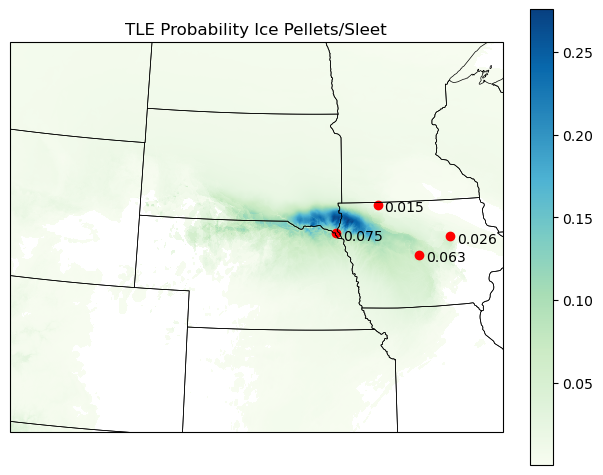

In [118]:
ptype = 'icep'
longn_ptype = 'Ice Pellets/Sleet'

prob = ds[f'ML_{ptype}'].values
prob_labels = [prob[i][j] for i, j in indices]
lat_labels = [ds.latitude[i][j] for i, j in indices]
lon_labels = [ds.longitude[i][j] for i, j in indices]

projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
ax.add_feature(cfeature.STATES, linewidth=0.5)

for res in json_data['results']:
    if res['description'] == longn_ptype:
        coord = res['geom']['coordinates']
        ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='red', label=res['description'])

# Annotate each point with its label
for i, txt in enumerate(prob_labels):
    ax.annotate(f'{txt:.3f}', (lon_labels[i], lat_labels[i]), xytext=(5,-5), textcoords='offset points', transform=ccrs.PlateCarree())

plt.colorbar(pcm, ax=ax, fraction=0.042)
plt.title(f'TLE Probability {longn_ptype}')

Now let's look at the hour BEFORE the valid time to see if there's any differences.

In [124]:
json_data = get_json(reqheaders, 2024, 3, 24, 13)
json_data['results'][:2]

Request Successful


[{'id': 3908716,
  'obtime': '2024-03-24T13:01:57Z',
  'category': 'Rain/Snow',
  'description': 'Snow and/or Graupel',
  'description_id': 8,
  'geom': {'type': 'Point',
   'coordinates': [-92.70174270504405, 44.927186910104865]}},
 {'id': 3908717,
  'obtime': '2024-03-24T13:03:32Z',
  'category': 'Rain/Snow',
  'description': 'Snow and/or Graupel',
  'description_id': 8,
  'geom': {'type': 'Point', 'coordinates': [-90.8989557, 46.6733116]}}]

Text(0.5, 1.0, 'TLE 2024-03-24 1400 Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

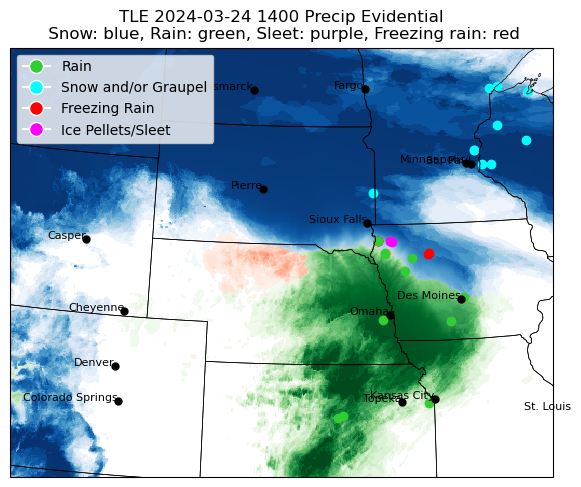

In [126]:
ax = plot_ptype(ds)
plot_mping(ax, json_data, colors)
plt.title(f'TLE {valid_time} Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

Text(0.5, 1.0, 'TLE 2024-03-24 1400 Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

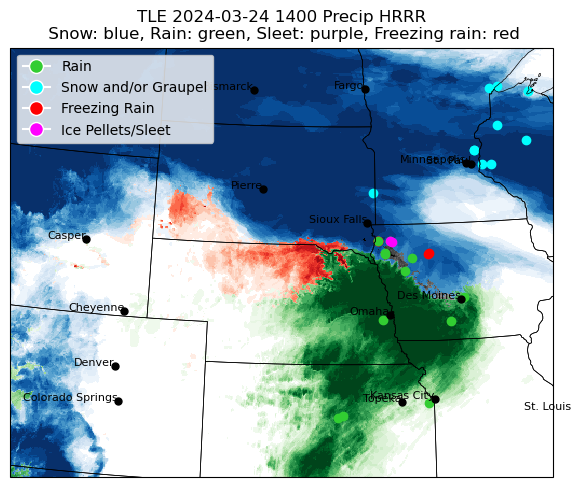

In [127]:
ax = plot_hrrr_ptype(ds)
plot_mping(ax, json_data, colors)
plt.title(f'TLE {valid_time} Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

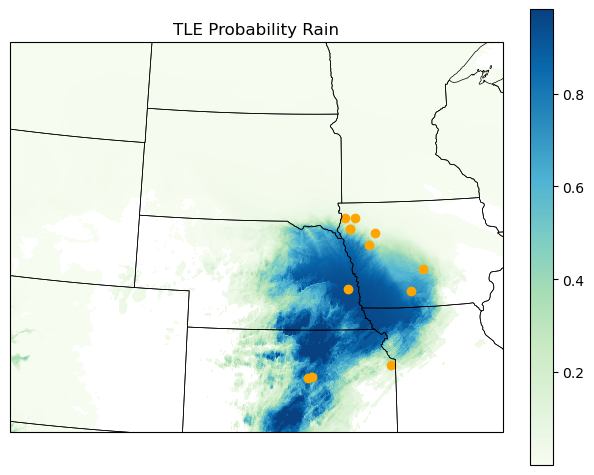

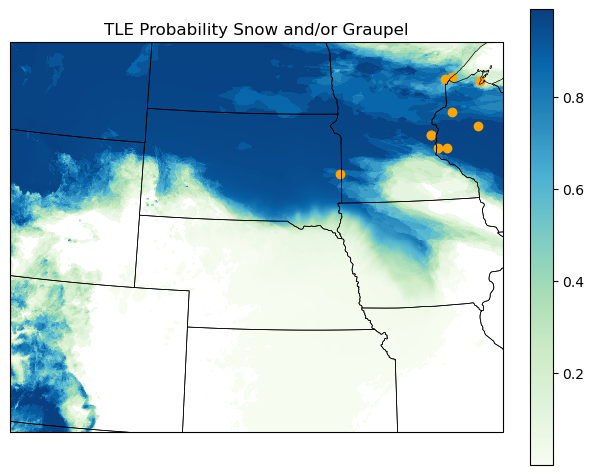

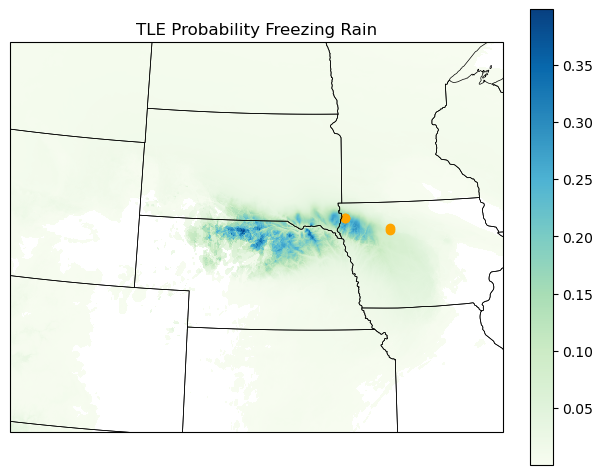

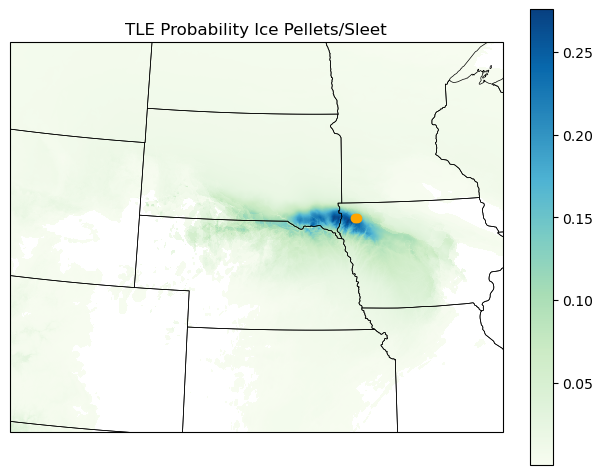

In [128]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='orange', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'TLE Probability {longn_ptype}')

(439, 528)
Coordinate 264.0969469449086, 43.07355742327542 is closest to grid point (lon, lat) = (264.11334228515625, 43.06833267211914) at row 245, col 358
Coordinate 264.0225547, 43.0801873 is closest to grid point (lon, lat) = (264.03973388671875, 43.069252014160156) at row 245, col 356


Text(0.5, 1.0, 'TLE Probability Ice Pellets/Sleet')

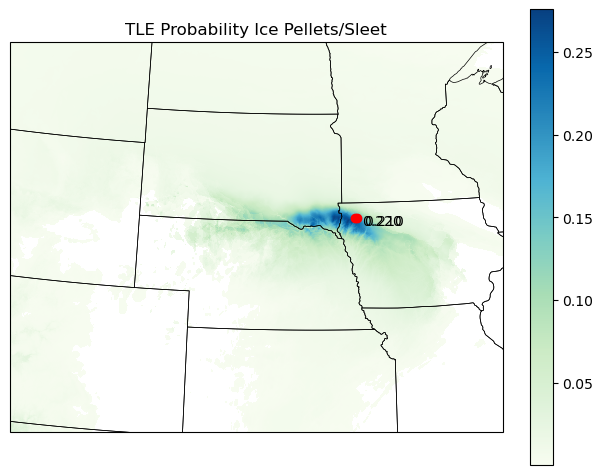

In [133]:
icep_coords = []
for res in json_data['results']:
    if res['description'] == 'Ice Pellets/Sleet':
        coord = res['geom']['coordinates']
        icep_coords.append((coord[0] + 360, coord[1]))

lat = ds.latitude.values
lon = ds.longitude.values
print(lat.shape)
indices = []
lcc = ccrs.PlateCarree()
for lon_p, lat_p in icep_coords:
    x_p, y_p= lcc.transform_point(lon_p, lat_p, src_crs=ccrs.PlateCarree())
    dist = (lon_p - (lon)) ** 2 + (lat_p - lat) ** 2
    i, j = np.unravel_index(np.argmin(dist.ravel()), lon.shape)
    indices.append((i, j))
    print(f"Coordinate {lon_p}, {lat_p} is closest to grid point (lon, lat) = ({lon[i][j]}, {lat[i][j]}) at row {i}, col {j}")

ptype = 'icep'
longn_ptype = 'Ice Pellets/Sleet'

prob = ds[f'ML_{ptype}'].values
prob_labels = [prob[i][j] for i, j in indices]
lat_labels = [ds.latitude[i][j] for i, j in indices]
lon_labels = [ds.longitude[i][j] for i, j in indices]

projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
ax.add_feature(cfeature.STATES, linewidth=0.5)

for res in json_data['results']:
    if res['description'] == longn_ptype:
        coord = res['geom']['coordinates']
        ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='red', label=res['description'])

# Annotate each point with its label
for i, txt in enumerate(prob_labels):
    ax.annotate(f'{txt:.3f}', (lon_labels[i], lat_labels[i]), xytext=(5,-5), textcoords='offset points', transform=ccrs.PlateCarree())

plt.colorbar(pcm, ax=ax, fraction=0.042)
plt.title(f'TLE Probability {longn_ptype}')

## Case Study 2: 2023-12-25 1400

In [140]:
valid_time = '2023-12-25 1400'
tle_files = get_tle_files(base_path, valid_time, n_members)
json_data = get_json(reqheaders, 2023, 12, 25, 14)
ds = load_data(tle_files, variables)

Request Successful


Text(0.5, 1.0, 'TLE 2023-12-25 1400 Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

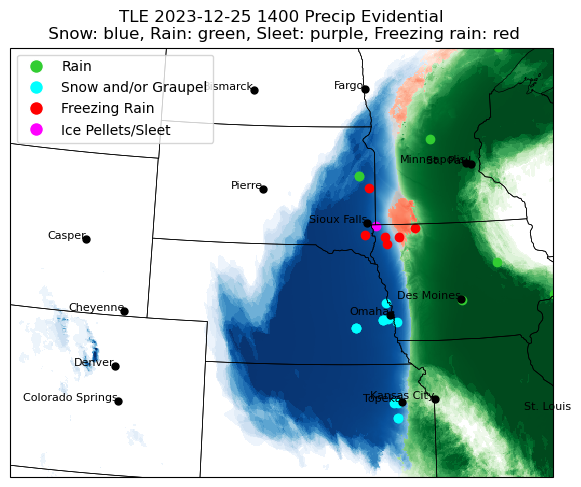

In [141]:
ax = plot_ptype(ds)
plot_mping(ax, json_data, colors)
plt.title(f'TLE {valid_time} Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

Text(0.5, 1.0, 'TLE 2023-12-25 1400 Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

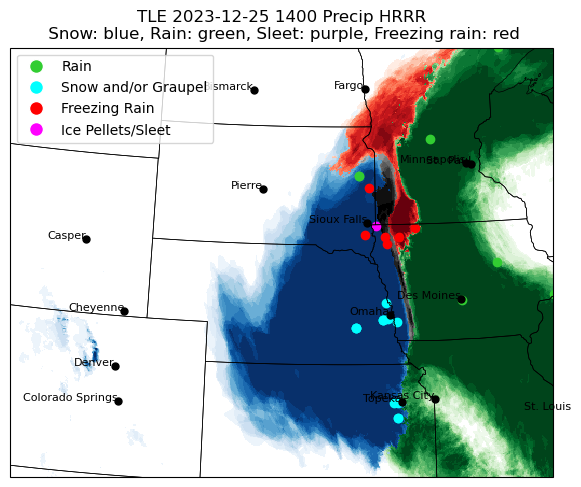

In [142]:
ax = plot_hrrr_ptype(ds)
plot_mping(ax, json_data, colors)
plt.title(f'TLE {valid_time} Precip HRRR\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

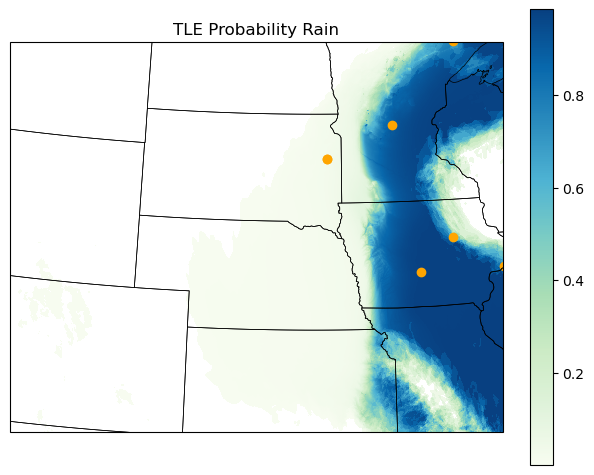

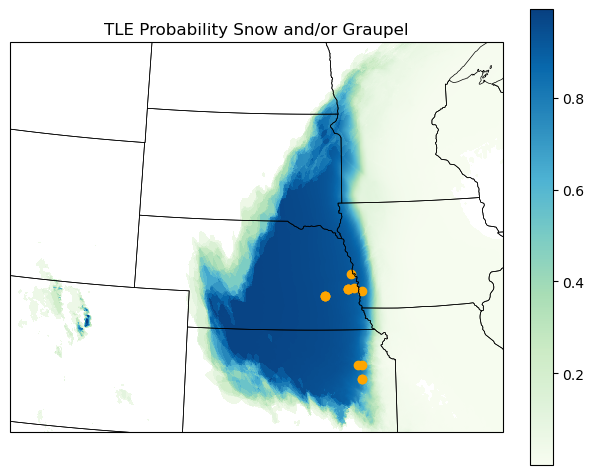

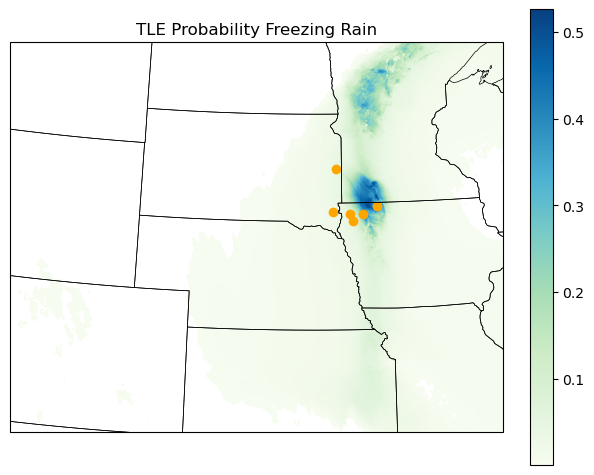

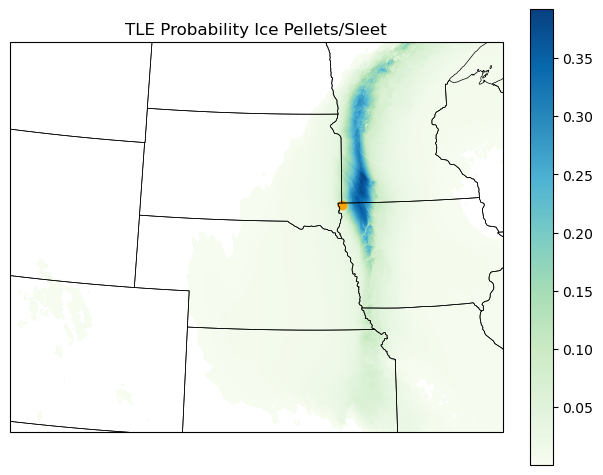

In [143]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='orange', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'TLE Probability {longn_ptype}')

Looking at the hour ahead

In [145]:
json_data = get_json(reqheaders, 2023, 12, 25, 13)

Request Successful


Text(0.5, 1.0, 'TLE 2023-12-25 1400 Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

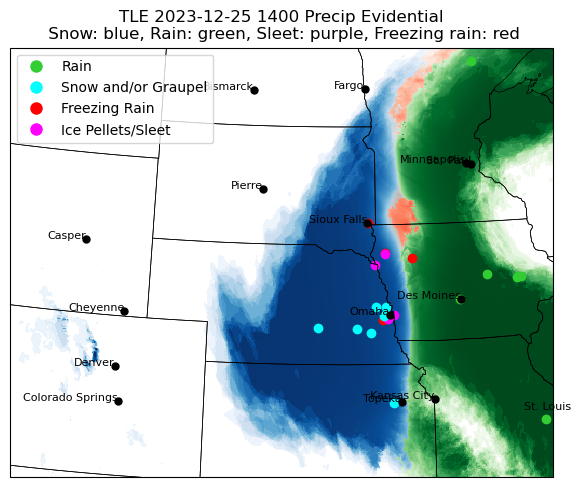

In [146]:
ax = plot_ptype(ds)
plot_mping(ax, json_data, colors)
plt.title(f'TLE {valid_time} Precip Evidential\n Snow: blue, Rain: green, Sleet: purple, Freezing rain: red')

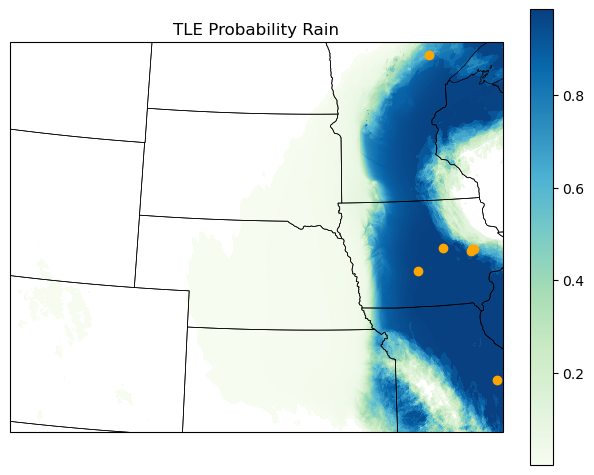

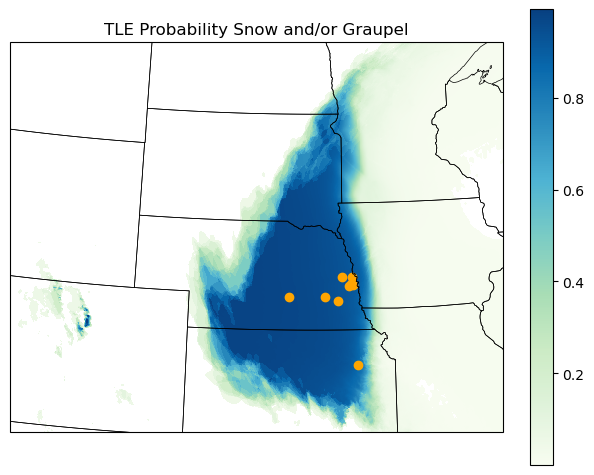

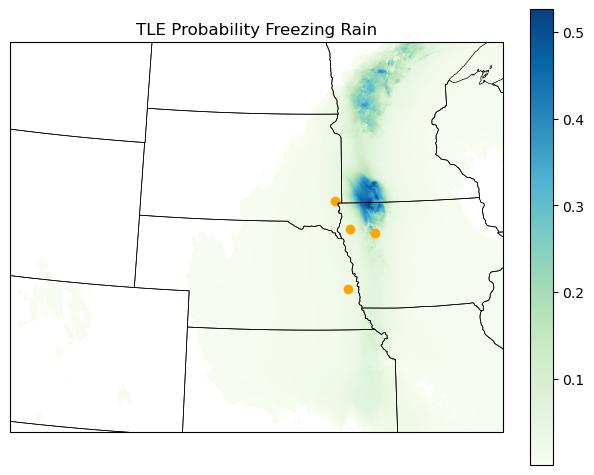

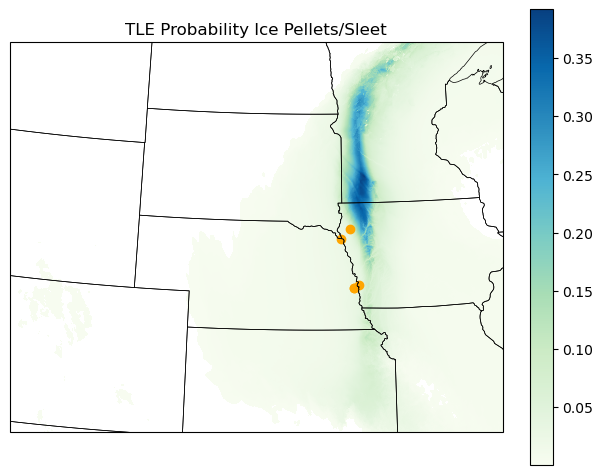

In [147]:
ptypes = ['rain', 'snow', 'frzr', 'icep']
longnames = ['Rain', 'Snow and/or Graupel', 'Freezing Rain', 'Ice Pellets/Sleet']
for ptype, longn_ptype in zip(ptypes, longnames):
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='orange', label=res['description'])
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'TLE Probability {longn_ptype}')

In [152]:
def plot_prob_coords(ptype, longn_ptype):
    coords = []
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            coords.append((coord[0] + 360, coord[1]))
    
    lat = ds.latitude.values
    lon = ds.longitude.values
    print(lat.shape)
    indices = []
    lcc = ccrs.PlateCarree()
    for lon_p, lat_p in coords:
        x_p, y_p= lcc.transform_point(lon_p, lat_p, src_crs=ccrs.PlateCarree())
        dist = (lon_p - (lon)) ** 2 + (lat_p - lat) ** 2
        i, j = np.unravel_index(np.argmin(dist.ravel()), lon.shape)
        indices.append((i, j))
        #print(f"Coordinate {lon_p}, {lat_p} is closest to grid point (lon, lat) = ({lon[i][j]}, {lat[i][j]}) at row {i}, col {j}")
    
    prob = ds[f'ML_{ptype}'].values
    prob_labels = [prob[i][j] for i, j in indices]
    lat_labels = [ds.latitude[i][j] for i, j in indices]
    lon_labels = [ds.longitude[i][j] for i, j in indices]
    
    projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
    pcm = ax.pcolormesh(ds['longitude'], ds['latitude'], ds[f'ML_{ptype}'], transform=ccrs.PlateCarree(), cmap='GnBu')
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    
    for res in json_data['results']:
        if res['description'] == longn_ptype:
            coord = res['geom']['coordinates']
            ax.scatter(coord[0], coord[1], transform=ccrs.PlateCarree(), color='red', label=res['description'])
    
    # Annotate each point with its label
    for i, txt in enumerate(prob_labels):
        ax.annotate(f'{txt:.3f}', (lon_labels[i], lat_labels[i]), xytext=(5,-5), textcoords='offset points', transform=ccrs.PlateCarree())
    
    plt.colorbar(pcm, ax=ax, fraction=0.042)
    plt.title(f'TLE Probability {longn_ptype}')

(439, 528)


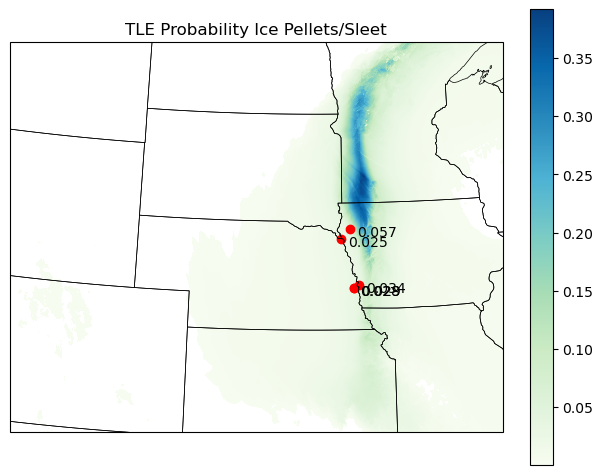

In [153]:
plot_prob_coords("icep", "Ice Pellets/Sleet")

(439, 528)


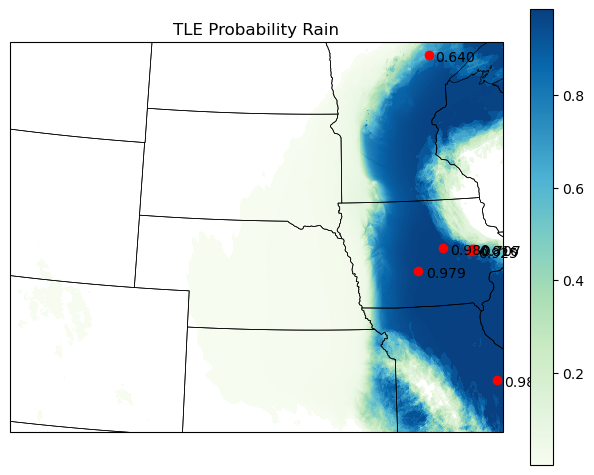

In [154]:
plot_prob_coords("rain", "Rain")

(439, 528)


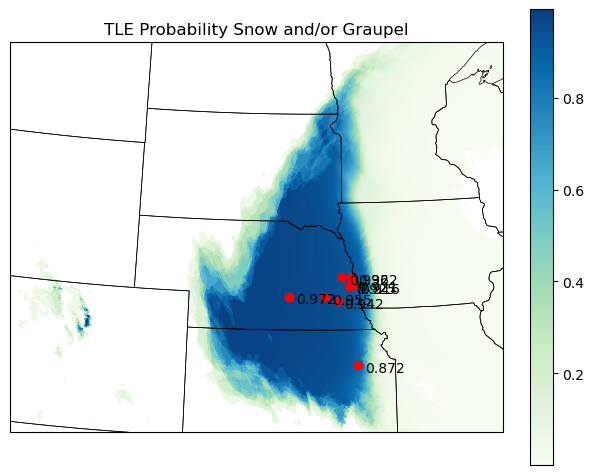

In [156]:
plot_prob_coords("snow", "Snow and/or Graupel")

(439, 528)


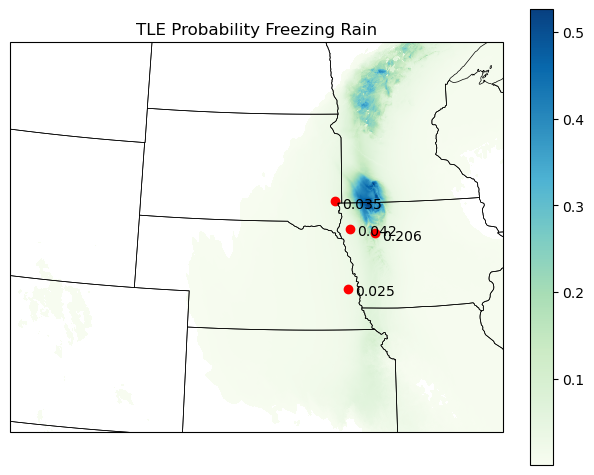

In [157]:
plot_prob_coords("frzr", "Freezing Rain")

Let's compare mping data to categorization for an entire precip event: 3-24-2024 to 3-26-2024. It's not exactly a perfect comparison since the precipitation features change over time, but hopefully we can get a general idea.

In [13]:
js_324 = get_json(reqheaders, 2024, 3, 24) # includes 0 to 24 hours.
js_325 = get_json(reqheaders, 2024, 3, 25)
js_326 = get_json(reqheaders, 2024, 3, 26)
json_data = [js_324, js_325, js_326]

Request Successful
Request Successful
Request Successful


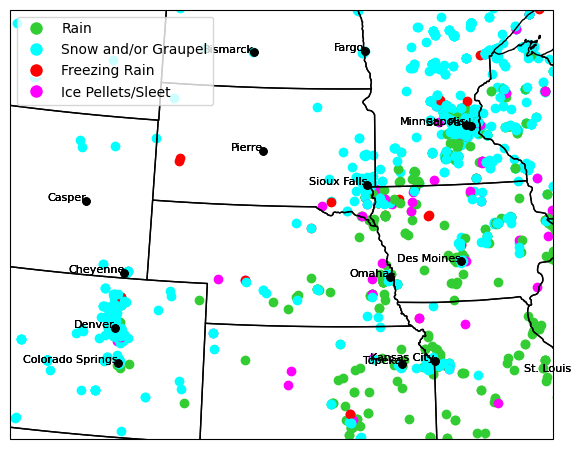

In [14]:
projection = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5, 38.5))
extent = [-108, -91, 37, 47.5]    
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
ax.set_extent([-108, -91, 37, 47.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES)

for i, js in enumerate(json_data):
    plot_mping(ax, json_data, colors)

Plotting evidential points will require more logic